# SentiScope

## Baseline Model

In [13]:
# Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_predict, train_test_split, learning_curve
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import joblib
from datetime import datetime

## Model comparison via GridSearch (small dataset)

In [14]:
#Import pre-processed training data | 36K observations
n_rows = 36000
clean_df_small = pd.read_csv("../raw_data/train_df_ml_clean.csv", nrows=n_rows)
clean_df_small = clean_df_small.dropna(subset=["clean_text"])
display(clean_df_small.head(), clean_df_small.shape, clean_df_small["label"].value_counts(normalize=True))

,label,text,clean_text
0,1,Stuning even for the non-gamer: This sound tra...,stuning even for the nongamer this sound track...
1,1,The best soundtrack ever to anything.: I'm rea...,the best soundtrack ever to anything im readin...
2,1,Amazing!: This soundtrack is my favorite music...,amazing this soundtrack is my favorite music o...
3,1,Excellent Soundtrack: I truly like this soundt...,excellent soundtrack i truly like this soundtr...
4,1,"Remember, Pull Your Jaw Off The Floor After He...",remember pull your jaw off the floor after hea...


(36000, 3)

label
1    0.505
0    0.495
Name: proportion, dtype: float64

In [15]:
#Split training data into X and y | 36K observations
X_train_small = clean_df_small["clean_text"]
y_train_small = clean_df_small["label"].astype(int)
display(X_train_small.shape, y_train_small.shape)

(36000,)

(36000,)

In [16]:
# Implement GridSearch and model comparison | 36K observations
# Cross-validate
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Vectorize
vectorizer = TfidfVectorizer(ngram_range=(1,2))

# Define params
params = {
    "vectorizer__max_features": [1000, 5000, 10000],
    "model__C": [0.01, 0.1, 1, 10]
}

# Define models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Linear SVC": LinearSVC(max_iter=1000)
}

# Run GridSearch
best_params_list = []
for name, model in models.items():
    print(f"GridSearchCV for {name}")

    pipeline = Pipeline([
        ("vectorizer", vectorizer),
        ("model", model)
    ])

    grid = GridSearchCV(
        pipeline,
        param_grid=params,
        cv=cv,
        scoring="accuracy",
        n_jobs=-1,
        verbose=1
    )

    grid.fit(X_train_small, y_train_small)

    print(f"Best CV accuracy: {grid.best_score_}")
    print(f"Best parameters: {grid.best_params_}")
    best_params = {
        "model": name,
        "max_features": grid.best_params_["vectorizer__max_features"],
        "C": grid.best_params_["model__C"]
    }
    best_params_list.append(best_params)

    # Create classification report
    y_pred = grid.best_estimator_.predict(X_train_small)

    print("Classification report:")
    print(classification_report(y_train_small, y_pred))

GridSearchCV for Logistic Regression
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best CV accuracy: 0.8965277777777777
Best parameters: {'model__C': 1, 'vectorizer__max_features': 10000}
Classification report:
              precision    recall  f1-score   support

           0       0.93      0.93      0.93     17820
           1       0.93      0.93      0.93     18180

    accuracy                           0.93     36000
   macro avg       0.93      0.93      0.93     36000
weighted avg       0.93      0.93      0.93     36000

GridSearchCV for Linear SVC
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best CV accuracy: 0.8972777777777777
Best parameters: {'model__C': 0.1, 'vectorizer__max_features': 10000}
Classification report:
              precision    recall  f1-score   support

           0       0.93      0.93      0.93     17820
           1       0.93      0.93      0.93     18180

    accuracy                           0.93     36000
   macro a

In [6]:
# Save best params
best_params_df = pd.DataFrame(best_params_list)
best_params_df.set_index("model", inplace=True)
display(best_params_df)

,max_features,C
model,,
Logistic Regression,10000,10
Linear SVC,10000,1


## Learning curve for LogReg (large dataset)

In [ ]:
#Import pre-processed training data | 360K observations
n_rows = 360000
clean_df_large = pd.read_csv("../raw_data/train_df_ml_clean.csv", nrows=n_rows)
clean_df_large = clean_df_large.dropna(subset=["clean_text"])
display(clean_df_large.head(), clean_df_large.shape, clean_df_large["label"].value_counts(normalize=True))

,label,text,clean_text
0,1,Stuning even for the non-gamer: This sound tra...,stuning even for the nongamer this sound track...
1,1,The best soundtrack ever to anything.: I'm rea...,the best soundtrack ever to anything im readin...
2,1,Amazing!: This soundtrack is my favorite music...,amazing this soundtrack is my favorite music o...
3,1,Excellent Soundtrack: I truly like this soundt...,excellent soundtrack i truly like this soundtr...
4,1,"Remember, Pull Your Jaw Off The Floor After He...",remember pull your jaw off the floor after hea...


(5000, 3)

label
0    0.5384
1    0.4616
Name: proportion, dtype: float64

In [8]:
#Split training data into X and y | 36K observations
X_train_large = clean_df_large["clean_text"]
y_train_large = clean_df_large["label"].astype(int)
display(X_train_large.shape, y_train_large.shape)

(5000,)

(5000,)

In [22]:
max_features = best_params_df.loc["Logistic Regression"]["max_features"].astype(int)
logreg_C = best_params_df.loc["Logistic Regression"]["C"].astype(int)

vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=max_features)
X_train_large_vec = vectorizer.fit_transform(X_train_large)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

model = LogisticRegression(C=logreg_C, max_iter=1000)

[learning_curve] Training set sizes: [ 400 1300 2200 3100 4000]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    2.8s finished


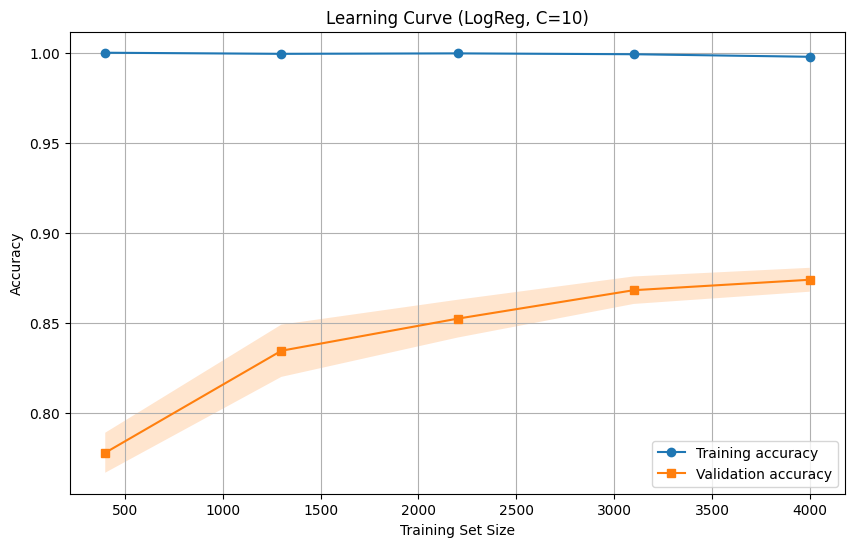

In [10]:
# Estimate learning curve inputs
train_sizes, train_scores, val_scores = learning_curve(
    estimator=model,
    X=X_train_large_vec,
    y=y_train_large,
    train_sizes=np.linspace(0.1, 1.0, 5),
    cv=cv,
    scoring="accuracy",
    n_jobs=-1,
    verbose=1
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# Plot learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, marker="o", label="Training accuracy")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2)

plt.plot(train_sizes, val_mean, marker="s", label="Validation accuracy")
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.2)

plt.title(f"Learning Curve (LogReg, C={logreg_C})")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

## Training, scoring and saving of LogReg (large dataset)

In [ ]:
#Import pre-processed test data
test_df = pd.read_csv("../raw_data/test_df_ml_clean.csv")
test_df = test_df.dropna(subset=["clean_text"])
display(test_df.head(), test_df.shape, test_df["label"].value_counts(normalize=True))

,label,text,clean_text
0,1,Great CD: My lovely Pat has one of the GREAT v...,great cd my lovely pat ha one of the great voi...
1,1,One of the best game music soundtracks - for a...,one of the best game music soundtrack for a ga...
2,0,Batteries died within a year ...: I bought thi...,battery died within a year i bought this charg...
3,1,"works fine, but Maha Energy is better: Check o...",work fine but maha energy is better check out ...
4,1,Great for the non-audiophile: Reviewed quite a...,great for the nonaudiophile reviewed quite a b...


(10000, 3)

label
1    0.5125
0    0.4875
Name: proportion, dtype: float64

In [28]:
#Split training data into X and y | 36K observations
X_test = test_df["clean_text"]
y_test = test_df["label"].astype(int)
display(X_test.shape, y_test.shape)

(10000,)

(10000,)

In [29]:
X_test_vec = vectorizer.transform(X_test)

In [30]:
# Train and score Logistic Regression with optimized params
print("Training model...")
model.fit(X_train_large_vec, y_train_large)

# Check performance on test set
print("Test performance:")
y_test_pred = model.predict(X_test_vec)
acc_test = accuracy_score(y_test, y_test_pred)
print(f"Accuracy: {acc_test}")
print(classification_report(y_test, y_test_pred))

Training model...
Test performance:
Accuracy: 0.8613
              precision    recall  f1-score   support

           0       0.85      0.87      0.86      4875
           1       0.87      0.86      0.86      5125

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



In [31]:
# Save model
timestamp = datetime.now().strftime("%Y%m%d_%H%M")
model_path = f"logreg_base_model_{timestamp}.pkl"
joblib.dump(pipeline, model_path)
print(f"Model saved to: {model_path}")

Model saved to: logreg_base_model_20250611_1120.pkl


## Viszualization of User Input

In [57]:
import string
import re
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
def clean_text(text):
    #No whitespaces in beginning or end
    text = text.strip()
    #lowercase
    text= text.lower()
    #remove numbers
    text = re.sub(r'\b\d+\b', '', text)

    text = re.sub(rf"[{re.escape(string.punctuation)}]", '', text)

    # Tokenizing
    tokenized = word_tokenize(text)
    # Lemmatizing
    lemmatizer = WordNetLemmatizer()
    lemmatized = [lemmatizer.lemmatize(word) for word in tokenized]
    text = " ".join(lemmatized)
    return text

In [ ]:
from IPython.display import display, HTML

def visualize_input_importance(text, vectorizer, model, base_size=16, scale=40, top_n=2):
    # Clean and vectorize input
    words = text.split()
    cleaned_text = clean_text(text)
    cleaned_words = cleaned_text.split()
    X_input = vectorizer.transform([cleaned_text])
    feature_names = vectorizer.get_feature_names_out()
    coefs = model.coef_[0]

    # Get relevant inputs words with corresponding contributions
    input_indices = X_input.nonzero()[1]
    tfidf_values = X_input.toarray()[0][input_indices]
    input_tokens = [feature_names[i] for i in input_indices]
    word_coefs = coefs[input_indices]
    contributions = tfidf_values * word_coefs
    contrib_dict = dict(zip(input_tokens, contributions))

    # Find top word contributors
    sorted_items = sorted(contrib_dict.items(), key=lambda x: x[1])
    top_negative = [w for w, _ in sorted_items[:top_n]]
    top_positive = [w for w, _ in sorted_items[-top_n:]]

    # Visualize input with color for top negatives/ positives and font size based on contribution
    highlighted_text = ""
    for word, clean_word in zip(words, cleaned_words):
        contrib = contrib_dict.get(clean_word, 0)
        size = base_size + min(abs(contrib) * scale, scale)
        size = round(size, 1)
        color = "green" if clean_word in top_positive else "red" if clean_word in top_negative else "grey"

        highlighted_text += f'<span style="font-size:{size}px; color:{color}">{word}</span> '

    display(HTML(f"<p>{highlighted_text.strip()}</p>"))

In [82]:
user_input = "The service was slow and the product quality was amazing"
visualize_input_importance(user_input, vectorizer, model)